# Electrokinetics

## Table of Contents
1. [Introduction](#Introduction)
2. [Theoretical Background](#Theoretical-Background)
   1. [The Electrokinetic Equations](#The-Electrokinetic-Equations)
   2. [EOF in the Slit Pore Geometry](#EOF-in-the-Slit-Pore-Geometry)
3. [Simulation using ESPResSo](#Simulation-using-ESPResSo)
   1. [Setting up ESPResSo](#Setting-up-ESPResSo)
   2. [Mapping SI and Simulation Units](#Mapping-SI-and-Simulation-Units)
   3. [Setting up the slit pore system](#Setting-up-the-slit-pore-system)
4. [References](#References)
    

## Introduction

In recent years the lattice-Boltzmann method (LBM) has proven itself to be a viable way to introduce hydrodynamic interactions into coarse-grained MD simulations with moderate computational cost.
The success of the GPU LBM implementation in ESPResSo and similar developments in other software packages created demand for further developments in this area.
ESPResSo features two such algorithms, namely ELECTROHYDRODYNAMICS, and ELECTROKINETICS (EK).
Both of these make use of the LBM and extend it to coarse-grain not only the solvent molecules but also ionic solutes.
ELECTROHYDRODYNAMICS does so using a slip layer coupling for charged particles valid in the thin Debye layer (large salt concentration) limit [1], while EK explicitly treats the ionic solutes in a continuum fashion and is valid for a wide range of salt concentrations [2-4].

### Tutorial Outline

To make our first steps using ELECTROKINETICS we will work on one of the few systems for which analytic solutions for the electrokinetic equations exist: the slip pore geometry with a counterion-only electrolyte.
The same slit pore system is also treated in the LBM tutorial, but there, the ionic species were modeled as explicit particles.
For this system, the two approaches lead to exactly the same results [5].
Differences became significant for multivalent ions, very high salt concentrations, and very high surface charge, since then the mean-field approach the EK employs, is basically solving the Poisson-Nernst-Planck formalism plus the Navier-Stokes equation on a lattice.
This leads to significantly different results from explicit ion approaches [6-8].
This tutorial is mainly divided into two sections.
* **Theoretical Background** introduces the electrokinetic equations and the analytical solution for the slit pore system.
* **Simulation using ESPResSo** deals exclusively with the simulation. 

If you already know about simple diffusion-migration-advection equations, continuum electrostatics, and Navier-Stokes, then you can skip the first section.

## Theoretical Background


### The Electrokinetic Equations

In the following, we will derive the equations modeling the time evolution of the concentrations of dissolved species as well as the solvent in the standard electrokinetic model.
We do so, neglecting the salt ions' contribution to the overall mass density, which allows us to treat the dynamics of the ions and the fluid separately [8].
The solvent fluid will be modeled using the Navier-Stokes equations while we use a set of diffusion-migration-advection equations for the ionic species.


#### Ionic Species

The description starts with the ionic species' concentrations $c_{k}(\vec{r}, t)$ (number density) and the associated flux densities $\vec{j}_{k}(\vec{r}, t)$, for which mass conservation holds

\begin{equation}
\partial_{t} c_{k} = -\nabla \cdot\vec{j}_{k} . 
\end{equation}

Here $\vec{r}$ denotes the spatial coordinate and $t$ the time, while $k$ enumerates the ionic species.
The fluxes are caused by diffusion (due to density variations and external forces) and advection.

The advective contribution to the flux is given by

\begin{equation}
\vec{j}_{k}^{\mathrm{adv.}} = c_{k} \vec{u} ,
\end{equation}

where $\vec{u}(\vec{r}, t)$ denotes the fluid velocity (advective velocity).
This equation models advection as a simple co-movement of the dissolved ions with the surrounding fluid.
All inertial effects of the ions are neglected.

The diffusive behavior of the ions is best described in a reference frame co-moving with the local advective velocity $\vec{u}$.
We assume that the species' relative fluxes instantaneously relax to a local equilibrium.
This assumption allows us to derive the diffusive fluxes from a local free-energy density, which we define as

\begin{equation}
f \big( c_{k}(\vec{r}) \big) = \sum_{k} \underbrace{k_{\mathrm{B}}T c_{k}(\vec{r}) \left[ \log \left\lbrace \Lambda_{k}^{3} c_{k}(\vec{r}) \right\rbrace - 1 \right] }_{\mathrm{ideal~gas~contribution}} + \underbrace{z_{k} e c_{k}(\vec{r}) \Phi(\vec{r})}_{\mathrm{electrostatic~contribution}} ,
\end{equation}

with the $\Lambda_{k}$ the species' thermal de Broglie wavelengths, $z_{k}$ their valencies, and $\Phi(\vec{r})$ the electrostatic potential.
This free-energy density consists of only an ideal-gas and an electrostatic contribution.
The same assumptions form the basis of Poisson-Boltzmann (PB) theory.
Hence, the limitations of this model are the same as those of PB.
That means this model applies to monovalent ions at low to intermediate densities and surface charges [6,7,11,12].

The species' chemical potentials $\mu_{k}$ implied by the free-energy density read

\begin{equation}
\mu_{k}(\vec{r}) = \delta_{c_k} f(c_{k}\big( \vec r ) \big) = k_{\mathrm{B}}T \log(\Lambda_{k}^{3} c_{k}(\vec{r})) + z_{k} e \Phi(\vec{r}) .
\end{equation}

This in turn allows us to formulate the first-order approximation to the thermodynamic driving force as the gradient of the chemical potential, which we use to define an expression for the diffusive flux

\begin{aligned}
\vec{j}_{k}^{\mathrm{diff}} &= \xi_{k} \left( -c_{k} \nabla \mu_{k} \right) = -k_{\mathrm{B}}T \xi_{k} \nabla c_{k} - \xi_{k} z_{k} e c_{k} \nabla\Phi \\
&= -D_{k} \nabla c_{k} - \xi_{k} z_{k} e c_{k} \nabla \Phi .
\end{aligned}

Here, $\xi_{k}$ and $D_{k}$ denote the mobility and the diffusion coefficient of species $k$, which are related by the Einstein-Smoluchowski relation $D_{k} / \xi_{k} = k_{\mathrm{B}}T$ [12,13].

Finally, the total number density flux combining effects of diffusion and advection reads

\begin{equation}
\vec{j}_{k} = \vec{j}_{k}^{\mathrm{diff}} + \vec{j}_{k}^{\mathrm{adv.}} = -D_{k} \nabla c_{k} - \xi_{k} z_{k} e c_{k} \nabla \Phi + c_{k} \vec{u} , 
\end{equation}

where the first term represents Fick's law of diffusion in the absence of an external potential, the second term gives the additional flux due to an external (in this case electrostatic) potential, and the last term introduces the influence of the motion of the underlying solvent.

#### Electrostatics

The dynamics of the charged species in a typical micro- or nanofluidic system are slow compared to the relaxation of the electromagnetic fields.
This allows us to use stationary equations to model electromagnetic effects.
We further assume that the modeled species do not carry permanent magnetic dipoles and that electric currents in the system are small.
Under these conditions, the full set of Maxwell's equations reduces to the Poisson equation

\begin{equation}
\nabla^2 \Phi = - \frac{1}{\varepsilon} \sum_{k} z_{k} e c_{k} = -4 \pi l_\mathrm{B} k_{\mathrm{B}}T \sum_{k} z_{k} c_{k} . 
\end{equation}

Here $\varepsilon = \varepsilon_{0} \varepsilon_r$ denotes the product of the vacuum permittivity $\varepsilon_{0}$ with the relative permittivity of the solvent $\varepsilon_r$.
We have also used the Bjerrum-length

\begin{equation}
l_\mathrm{B} = \frac{e^{2}}{4 \pi \varepsilon k_{\mathrm{B}}T}.
\end{equation}

Finally, we have assumed that the permittivity is spatially homogeneous, since this will allow us to use efficient spectral methods to solve this equation.


#### Hydrodynamics

As said before, since the ionic species' contribute at most a few percent to the overall mass, we can safely approximate the overall fluid's mass by the mass of the solvent (typically water) and model the solvents velocity field $\vec{u}(\vec{r}, t)$ using the Navier-Stokes equations for an isotropic, incompressible Newtonian fluid

\begin{aligned}
\rho \big( \partial_t \vec{u} + \left(\vec{u} \cdot \nabla \right) \vec{u} \big) &= -\nabla p_H + \eta \nabla^{2} \vec{u} + \vec{f} ,\\
\nabla \cdot \vec u &= 0 .
\end{aligned}

where $p_H$ denotes the hydrostatic pressure, $\eta$ the shear viscosity, $\rho$ the density of the fluid, and $\vec{f}$ an external body force density.
For the assumption of incompressibility to hold, the Mach number needs to be small &ndash; a condition that is fulfilled for micro- and nanofluidic systems with flow velocities on the order of &mu;m/s.

Earlier we assumed that the ions' velocity relative to the fluid instantaneously relaxes to a stationary state and that this stationary velocity is given by the product of their mobility and the force exerted on them.
For this state to be stationary, all the momentum transferred into the ions by the external force needs to be dissipated into the fluid immediately.
From this we can conclude that the force density acting on the fluid must read

\begin{equation}
\vec{f} = \sum_{k} \vec{j}^\mathrm{diff}_k / \xi_{k} = -\sum_{k} (k_\mathrm{B}T \nabla c_{k} + z_{k} e c_{k} \nabla \Phi) .
\end{equation}

Summarizing, the set of electrokinetic equations we solve is given by

\begin{aligned}
\vec{j}_{k} &= -D_{k} \nabla c_{k} - \xi_{k} z_{k} e c_{k} \nabla \Phi + c_{k} \vec{u} ,\\
\partial_{t} c_{k} &= -\nabla \cdot\vec{j}_{k} ,\\
\nabla^2 \Phi &= -4 \pi l_\mathrm{B} k_\mathrm{B}T \textstyle\sum_{k} z_{k} c_{k} ,\\
\rho \big( \partial_t \vec{u} + (\vec{u} \cdot \nabla ) \vec{u} \big) &= -\nabla p_H + \eta \nabla^{2} \vec{u} - \textstyle\sum_{k} (k_\mathrm{B}T \nabla c_{k} + z_{k} e c_{k} \nabla \Phi) ,\\
\nabla \cdot \vec{u} &= 0 .
\end{aligned}


\begin{aligned}
\vec{j}_{k} &= -D_{k} \nabla c_{k} - \xi_{k} z_{k} e c_{k} \nabla \Phi + c_{k} \vec{u} ,\\
\partial_{t} c_{k} &= -\nabla \cdot\vec{j}_{k} ,\\
\partial_{t} c_{k} &= -\nabla \cdot\left(-D_{k} \nabla c_{k} - \xi_{k} z_{k} e c_{k} \nabla \Phi + c_{k} \vec{u}\right) ,\\
\nabla^2 \Phi &= -4 \pi l_\mathrm{B} k_\mathrm{B}T \textstyle\sum_{k} z_{k} c_{k} ,\\
0 &= -\nabla p_H - \textstyle\sum_{k} (k_\mathrm{B}T \nabla c_{k} + z_{k} e c_{k} \nabla \Phi) ,\\
\nabla \cdot \vec{u} &= 0 .
\end{aligned}

### EOF in the Slit Pore Geometry

The slit pore system depicted in Fig. 1 consists of two like charged parallel plates of infinite extent, confining a solution of water and the plates' counterions.

<figure>
    <img src='figures/schlitzpore_3d.png' alt='missing' style="width: 500px;"/>
    <center>
    <figcaption>Figure 1: Slit pore system and coordinate system used for the analytical calculations.</figcaption>
    </center>
</figure>

Due to the net neutrality of the system and the translational symmetry in directions parallel to the plates, the potential outside the two plates must be constant.
This means that using periodic or non-periodic boundary conditions makes no difference.
As the system is in equilibrium in the normal direction, the electrokinetic equations for this dimension reduce to the Poisson-Boltzmann equation for the electrostatic potential, which reads
\begin{equation}
\partial_x^2 \Phi(x) = -4 \pi \, k_\mathrm{B}T \, l_\mathrm{B} \, ze \, c_0 \cdot \exp{\left(-\frac{ze\Phi(x)}{k_\mathrm{B}T}\right)} \; ,
\end{equation}
where $x$ denotes the direction normal to the plates.
The constant $c_0$ has to be chosen such that charge neutrality is fulfilled.
Multiplying by $2 \partial_x \Phi(x)$ and applying the inverse chain rule further reduces the equation to first order.
Subsequent separation of variables yields the solution
\begin{equation}
\Phi(x) = -\frac{k_\mathrm{B}T}{ze} \cdot \log \left[ \frac{C^2}{8 \pi \, k_\mathrm{B}T \, l_\mathrm{B}} \cdot \cos^{-2}\left( \frac{zeC}{2 k_\mathrm{B}T} \cdot x\right) \right], \quad \left| \frac{zeC}{2 k_\mathrm{B}T} \cdot x \right| < \frac \pi 2\; .
\end{equation}
Refer to [5] for details on this calculation.
Knowing that the counterion density $c$ resembles a Boltzmann distribution in the potential $ze \Phi$ leads to the expression
\begin{equation}
c(x) = \frac{C^2}{8 \pi \, k_\mathrm{B}T \, l_\mathrm{B}} \cdot \cos^{-2} \left( \frac{zeC}{2 k_\mathrm{B}T} \cdot x \right) \; .
\end{equation}
The constant $C$ is determined by fixing the number of counterions or requiring the E-field to vanish outside the volume contained by the plates.
Both yields
\begin{equation}
C \cdot \tan \left( \frac{zed}{4 k_\mathrm{B}T} \cdot C \right) = -4 \pi \, k_\mathrm{B}T \, l_\mathrm{B} \sigma \; ,
\end{equation}
where $d$ denotes the distance between the plates and $\sigma$ their (constant) surface charge density.

Applying an electric field along one of the directions parallel to the plates does not influence the charge distribution in the normal direction, which allows us to write down the hydrodynamic equations for the parallel direction.
After eliminating all terms from the Navier-Stokes Equations, which vanish due to symmetry, we are left with
\begin{equation}
\frac{\partial_x^2 v_y(x)}{\partial x^2} = -\frac{q E C^2}{8 \, k_\mathrm{B}T \, l_\mathrm{B} \, \eta} \cdot \cos^{-2} \left( \frac{qC}{2 k_\mathrm{B}T} \cdot x \right) \; ,
\end{equation}
which yields, by means of simple integration and the application of no-slip boundary conditions
\begin{equation}
v_y(x) = \frac{E}{2 \pi \, l_\mathrm{B} \, \eta \, ze} \cdot \log \left[ \frac{\cos \left( \frac{zeC}{2 k_\mathrm{B}T} \cdot x \right)}{\cos \left( \frac{zeC}{2 k_\mathrm{B}T} \cdot \frac d 2 \right)} \right] \; .
\end{equation}

With this tutorial comes a Python script <tt>eof_analytical.py</tt>, which evaluates all these expressions on the same grid as is used in the upcoming simulation.

## Simulation using ESPResSo

### Setting up ESPResSo

To use the electrokinetics solver in ESPResSo enable the features <tt>ELECTROKINETICS</tt> and <tt>EK_BOUNDARIES</tt> during the build process.

### Mapping SI and Simulation Units

ESPResSo does not predefine any unit system.
This makes it more flexible but also requires us to spend some thought on the conversion from SI units to simulation units and back.
Since most first time users have trouble with this, we will go through that process in detail here.
	
Important to note is that ESPResSo's unit system is nothing more than a rescaled variant of the SI system.
All physical formulas you are used to in the SI system remain valid and you can use them to find relations between your units.
Let's start by choosing a unit of length.
Since we are going to deal with Debye layers with extensions of nanometers, a sensible choice is

\begin{equation}
[x]=1\mathrm{nm}.
\end{equation}

The involved energies are of the magnitude of $k_{\mathrm{B}}T$.
We will simulate our system at room temperature ($300\mathrm{K}$), hence we use as unit of energy
\begin{equation}
[E]=k_\mathrm{B}\cdot 300\mathrm{K}\approx 4.14 \cdot 10^{-21}\mathrm{J}.
\end{equation}

By default ESPResSo has no concept for particle masses (but the feature can be activated).
That means all particle masses are assumed to be $1\,[\mathrm{m}]$, which forces us to use the particle mass as mass unit.
For this simulation we use the mass of sodium ions, which is
\begin{equation}
[m]=23\mathrm{u}\approx 3.82\cdot 10^{-26}\mathrm{kg}.
\end{equation}

For the relation
\begin{equation}
E=\frac 1 2 mv^2
\end{equation}

to hold, the unit of time has to be defined so that
\begin{equation}
[E]=[m]\cdot\frac{[x]^2}{[t]^2}.
\end{equation}

From that we get the missing unit of time
\begin{equation}
[t]=[x]\cdot\sqrt{\frac{[m]}{[E]}}=1\mathrm{nm}\cdot\sqrt{\frac{23\mathrm{u}}{k_B\cdot 300\mathrm{K}}}\approx 3.03760648\cdot 10^{-12}\mathrm{s}\approx 3.04\mathrm{ps}.
\end{equation}

The last unit we need is the one of charge.
We choose it to be the elementary charge
\begin{equation}
[q]=e\approx 1.60\cdot 10^{-19}\mathrm{C}.
\end{equation}

We now have all the units necessary to convert our simulation parameters.

|parameter |value (SI units) | value (simulation units)|
|:---------|----------------:|------------------------:|
|channel width $d$ | $50\mathrm{nm}$ | $50\mathrm{[x]}$|
|thermal energy $k_B T$ | $k_B\cdot 300\mathrm{K}$ | $1\mathrm{[E]}$|
|Bjerrum length $l_B$ | $0.7095\mathrm{nm}$ | $0.7095\mathrm{[x]}$|
|counterion charge $q$ | $1e$ | $1\mathrm{[q]}$|
|counterion diffusion coefficient $D$ | $2.0\cdot 10^{-9}\mathrm{m^2/s}$ | $0.006075\mathrm{[x]^2/[t]}$|
|solvent density $\rho$ | $1.0\cdot 10^{3}\mathrm{kg/m^3}$ | $26.18\mathrm{[m]/[x]^3}$|
|solvent dynamic viscosity $\eta$ | $1.0\cdot 10^{-3}\mathrm{Pa}\mathrm{s}$ | $79.53\mathrm{[m]/([x][t])}$|
|external electric field $E$ | $2.585\cdot 10^{6}\mathrm{V/m}$ | $0.1\mathrm{[E]/([q][x])}$|


ESPResSo determines the strength of the electrostatic interactions via the Bjerrum-length $l_\mathrm{B}$.
That is the length for which the electrostatic interaction energy of two elementary charges equals the thermal energy

\begin{equation}
k_\mathrm{B} T=\frac{e^2}{4\pi\varepsilon_0\varepsilon_r}\cdot\frac 1 {l_\mathrm{B}}.
\end{equation}

This yields for water at $300K$ with $\varepsilon_r = 78.54$, a Bjerrum length of $l_\mathrm{B}\approx 0.7095\mathrm{nm}$.

### Setting up the slit pore system

The script for this simulation comes with this tutorial and is called <tt>eof_electrokinetics.py</tt>.
All used commands are documented in the User's Guide in the section called **Electrokinetics**.

We first set up a periodic simulation box of the desired dimensions.
Note that the dimensions are, of course, given in simulation units.

In [1]:
# Initializing espresso modules and the numpy package
import espressomd
import espressomd.electrokinetics
import espressomd.ekboundaries
import espressomd.shapes

espressomd.assert_features(['CUDA', 'ELECTROKINETICS'])

import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

# Set the slit pore geometry where the width is the non-periodic part of the geometry
# the padding is used to ensure that there is no field outside the slit since the
# electrostatics is used with a 3D periodic FFT solver.

box_y = 6
box_z = 6
width = 50

padding = 1
box_x = width + 2 * padding

system = espressomd.System(box_l=[box_x, box_y, box_z])

We then store all the parameters we calculated earlier.
At this point, these parameters only reside in Python variables.
They will only be used by ESPResSo once they are being passed to the respective initialization functions.

In [2]:
# Set the electrokinetic parameters

agrid = 1.0
dt = 0.2
kT = 1.0
bjerrum_length = 0.7095
D = 0.006075
valency = 1.0
viscosity_dynamic = 79.53
density_water = 26.15
sigma = -0.05
ext_force_density = [0.0, 0.1, 0.0]

Before we initialize the actual electrokinetics algorithm, we need to set the time step and some other parameters that are not actually used, but would otherwise lead to error messages.

In [3]:
# Set the simulation parameters

system.time_step = dt
system.cell_system.skin = 0.2
system.thermostat.turn_off()
integration_length = int(2e4)

We can now set up the electrokinetics algorithm.
All functionality pertaining to this algorithm is available through the <tt>electrokinetics</tt> submodule of <tt>espressomd</tt>.
Please note that the fluid viscosity is specified as a kinematic viscosity, which is the dynamic viscosity divided by the fluid density.
The kinematic viscosity is also required if you initialize the pure lattice-Boltzmann method.


In [4]:
# Set up the (LB) electrokinetics fluid
viscosity_kinematic = viscosity_dynamic / density_water
ek = espressomd.electrokinetics.Electrokinetics(agrid=agrid,
                                                lb_density=density_water,
                                                viscosity=viscosity_kinematic,
                                                friction=1.0,
                                                T=kT,
                                                prefactor=bjerrum_length)

The value of the friction parameter in the previous setup command is irrelevant, since we don't include any explicit particles in our simulation, but it's needed to pass the sanity check of the LB.

Next, we set up the individual ionic species.
In this case, we only set up one species of positively charged counterions.
The charge density is chosen in such a way, that it will cancel out the charges of the walls which are being inserted in the step afterwards.
After setting up the species, we have to add it to the electrokinetics instance. 

In [5]:
# Set up the charged and neutral species
density_counterions = -2.0 * sigma / width
counterions = espressomd.electrokinetics.Species(density=density_counterions,
                                                 D=D,
                                                 valency=valency,
                                                 ext_force_density=ext_force_density)

ek.add_species(counterions)

The <tt>EKBoundary</tt> command takes the keyword <tt>charge_density</tt> and the numerical charge density in simulation units as arguments.
The <tt>shape</tt> keyword takes an instance of a shape, which is provided by the <tt>shapes</tt> submodule and is the same as for the <tt>LBBoundary</tt> command.
Here we initialize two charged <tt>Wall</tt> boundaries.
To initialize the boundaries, we have to add them to the <tt>ekboundaries</tt> instance of the system class.
Finally, we initialize the electrokinetics algorithm with our setup by adding the electrokinetics instance as an actor to the system.

In [6]:
# Set up the walls confining the fluid
ek_wall_left = espressomd.ekboundaries.EKBoundary(charge_density=sigma / agrid,
                                                  shape=espressomd.shapes.Wall(normal=[1, 0, 0], dist=padding))
ek_wall_right = espressomd.ekboundaries.EKBoundary(charge_density=sigma / agrid,
                                                   shape=espressomd.shapes.Wall(normal=[-1, 0, 0], dist=-(padding + width)))

system.ekboundaries.add(ek_wall_left)
system.ekboundaries.add(ek_wall_right)

system.actors.add(ek)

After setting up the system, we integrate a sufficient number of time steps to relax the system into the stationary state and output the counterion density profile, the velocity profile, and the shear stress.
Since this system has translational symmetry in the x- and y-direction, we iterate over a line in the z direction and use the <tt>species[node].quantity</tt> command, to output local quantities.
You can instead also use the <tt>electrokinetics.write_vtk_quantity</tt> command to output the whole field at once in a ParaView-compatible format.

Density and velocity are not the only fields available for output.
Please refer to the User's Guide for all available options.

In [7]:
# Integrate the system
for i in tqdm.trange(100):
    system.integrator.run(integration_length)

# Output
position_list = []
density_list = []
velocity_list = []
pressure_xy_list = []

for i in range(int(box_x / agrid)):
    if (i * agrid >= padding) and (i * agrid < box_x - padding):
        position = i * agrid - padding - width / 2.0 + agrid / 2.0
        position_list.append(position)
        
        node_idxs = (i, int(box_y / (2 * agrid)), int(box_z / (2 * agrid)))

        # density
        density_list.append(counterions[node_idxs].density)

        # velocity
        velocity_list.append(ek[node_idxs].velocity[1])

        # xz component pressure tensor
        pressure_xy_list.append(ek[node_idxs].pressure_tensor[0, 1])

np.savetxt("eof_simulation.dat",
           np.column_stack((position_list,
                            density_list,
                            velocity_list,
                            pressure_xy_list)),
           header="#position calculated_density calculated_velocity calculated_pressure_xy")

100%|██████████| 100/100 [03:12<00:00,  1.92s/it]


We will now plot the counterion density, fluid velocity, and fluid shear stress
profiles along the direction perpendicular to the slit pore walls.

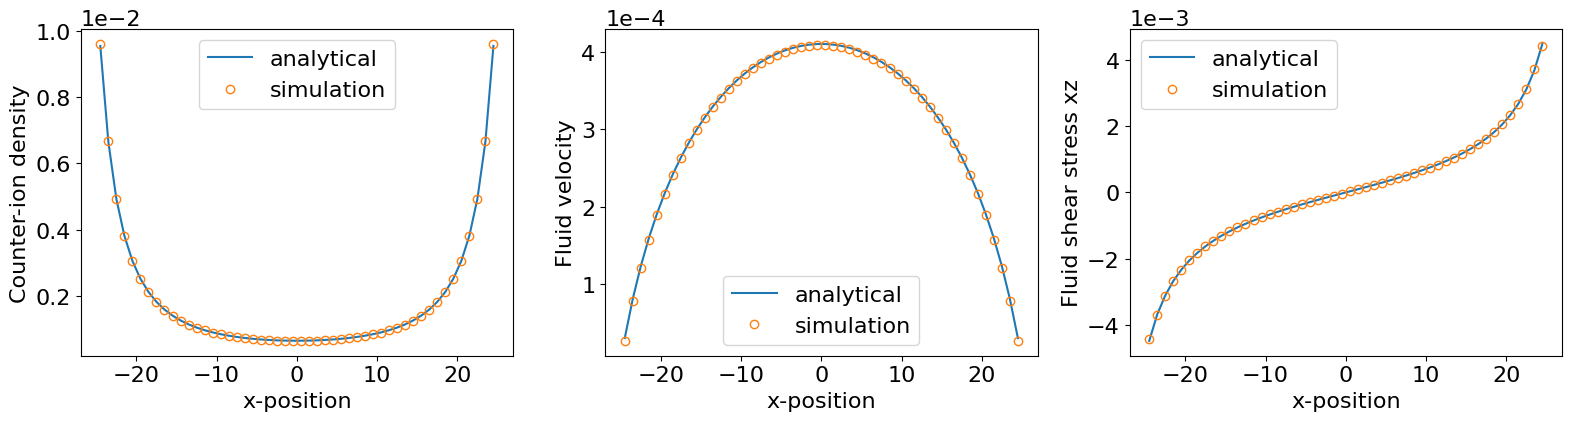

In [8]:
from scripts import eof_analytical # executes automatically upon import

# read analytical solution and simulation data
data_an = np.loadtxt("eof_analytical.dat")
data_ek = np.loadtxt("eof_simulation.dat")

fig1 = plt.figure(figsize=(16, 4.5))
ax = fig1.add_subplot(131)
ax.plot(data_an[:, 0], data_an[:, 1], label="analytical")
ax.plot(data_ek[:, 0], data_ek[:, 1], "o", mfc="none", label="simulation")
ax.set_xlabel("x-position")
ax.set_ylabel("Counter-ion density")
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
ax.legend(loc="best")

ax = fig1.add_subplot(132)
ax.plot(data_an[:, 0], data_an[:, 2], label="analytical")
ax.plot(data_ek[:, 0], data_ek[:, 2], "o", mfc="none", label="simulation")
ax.set_xlabel("x-position")
ax.set_ylabel("Fluid velocity")
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
ax.legend(loc="best")

ax = fig1.add_subplot(133)
ax.plot(data_an[:, 0], data_an[:, 3], label="analytical")
ax.plot(data_ek[:, 0], data_ek[:, 3], "o", mfc="none", label="simulation")
ax.set_xlabel("x-position")
ax.set_ylabel("Fluid shear stress xz")
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0, 0))
ax.legend(loc="best")

plt.tight_layout()
plt.show()

## References

[1] O. A. Hickey, C. Holm, J. L. Harden and G. W. Slater *Implicit Method for Simulating Electrohydrodynamics of Polyelectrolytes* Physical Review Letters, 2010  
[2] F. Capuani, I. Pagonabarraga and D. Frenkel *Discrete solution of the electrokinetic equations* The Journal of Chemical Physics, 2004  
[3] G. Rempfer *A Lattice based Model for Electrokinetics* Master's thesis, University of Stuttgart, 2013  
[4] G. Rempfer, G. B. Davies, C. Holm and J. de Graaf *Reducing spurious flow in simulations of electrokinetic phenomena* The Journal of Chemical Physics, 2016  
[5] G. Rempfer *Lattice-Boltzmann simulations in complex geometries* Bachelor's thesis, University of Stuttgart, Institute for Computational Physics, 2010  
[6] M. Deserno and C. Holm and S. May, *Fraction of Condensed Counterions around a Charged Rod: Comparison of Poisson-Boltzmann Theory and Computer Simulations* Macromolecules, 2000  
[7] C. Holm, P. K&eacute;kicheff and R. Podgornik *Electrostatic Effects in Soft Matter and Biophysics* Kluwer Academic Publishers, 2001  
[8] M. Deserno and C. Holm *Cell-model and Poisson-Boltzmann-theory: A brief introduction* Electrostatic Effects in Soft Matter and Biophysics, Kluwer Academic Publishers, 2001  
[9] J de Graaf., G. Rempfer and C. Holm *Diffusiophoretic Self-Propulsion for Partially Catalytic Spherical Colloids* IEEE T. Nanobiosci., 2014  
[10] M. Deserno *Counterion condensation for rigid linear polyelectrolytes* Universit&auml;t Mainz, 2000  
[11] J. de Graaf, N Boon, M Dijkstra and R. van Roij *Electrostatic interactions between Janus particles* The Journal of Chemical Physics, 2012   
[12] A. Einstein *&Uuml;ber die von der molekularkinetischen Theorie der W&auml;rme geforderte Bewegung von in ruhenden Fl&uuml;ssigkeiten suspendierten Teilchen* Annalen der Physik, 1905  
[13] M. von Smoluchowski *Zur kinetischen Theorie der Brownschen Molekularbewegung und der Suspensionen* Annalen der Physik, 1906  
